<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/classify_text_with_bert"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/collections/bert/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

# Attribute Threat Actors using Threat Intelligence Reports with BERT and Deep Learning


## About BERT

[BERT](https://arxiv.org/abs/1810.04805) and other Transformer encoder architectures have been wildly successful on a variety of tasks in NLP (natural language processing). They compute vector-space representations of natural language that are suitable for use in deep learning models. The BERT family of models uses the Transformer encoder architecture to process each token of input text in the full context of all tokens before and after, hence the name: Bidirectional Encoder Representations from Transformers. 

BERT models are usually pre-trained on a large corpus of text, then fine-tuned for specific tasks.


## Setup


In [1]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U "tensorflow-text==2.8.*"

     |████████████████████████████████| 4.9 MB 15.8 MB/s 


You will use the AdamW optimizer from [tensorflow/models](https://github.com/tensorflow/models).

In [2]:
!pip install -q tf-models-official==2.7.0
!pip install -q -U keras-tuner

     |████████████████████████████████| 1.8 MB 16.1 MB/s 
     |████████████████████████████████| 352 kB 92.3 MB/s 
     |████████████████████████████████| 1.1 MB 68.4 MB/s 
     |████████████████████████████████| 238 kB 66.7 MB/s 
     |████████████████████████████████| 116 kB 89.8 MB/s 
     |████████████████████████████████| 1.3 MB 67.8 MB/s 
     |████████████████████████████████| 99 kB 11.1 MB/s 
     |████████████████████████████████| 43 kB 2.3 MB/s 
     |████████████████████████████████| 135 kB 15.5 MB/s 
     |████████████████████████████████| 1.6 MB 67.8 MB/s 


In [3]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer
import keras_tuner as kt

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')


### Download the Threat Intelligence dataset

Let's download and extract the dataset, then explore the directory structure.


In [4]:
url = 'https://github.com/eyalmazuz/AttackAttributionDataset/archive/refs/heads/master.zip' 

dataset = tf.keras.utils.get_file('master.zip', url,
                                  extract=True, cache_dir='.',
                                  cache_subdir='')

1073152/Unknown - 0s 0us/step

Next, you will use the `text_dataset_from_directory` utility to create a labeled `tf.data.Dataset`.

The IMDB dataset has already been divided into train and test, but it lacks a validation set. Let's create a validation set using an 80:20 split of the training data by using the `validation_split` argument below.

Note:  When using the `validation_split` and `subset` arguments, make sure to either specify a random seed, or to pass `shuffle=False`, so that the validation and training splits have no overlap.

In [5]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 5
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'AttackAttributionDataset-master',
    batch_size=batch_size,
    validation_split=0.1,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.text_dataset_from_directory(
    'AttackAttributionDataset-master',
    batch_size=batch_size,
    validation_split=0.15,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


# val_ds = remaining_ds.take(int(len(remaining_ds)*0.5))

# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# test_ds = remaining_ds.skip(len(val_ds))

# test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 238 files belonging to 12 classes.
Using 215 files for training.
Found 238 files belonging to 12 classes.
Using 35 files for validation.


Let's take a look at a few reviews.

In [6]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Report: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Report: b"many security-minded organizations utilize code signing to provide an additional layer of security and authenticity for their software and files. code signing is carried out using a type of digital certificate known as a code-signing certificate. the process of code signing validates the authenticity of legitimate software by confirming that an application is from the organization who signed it. while code-signing certificates can offer more security, they can also live an unintended secret life providing cover for attack groups, such as the suckfly apt group. in late 2015, symantec identified suspicious activity involving a hacking tool used in a malicious manner against one of our customers. normally, this is considered a low-level alert easily defeated by security software. in this case, however, the hacktool had an unusual characteristic not typically seen with this type of file; it was signed with a valid code-signing certificate. many hacktools are made for less than et

## Loading models from TensorFlow Hub

Here you can choose which BERT model you will load from TensorFlow Hub and fine-tune. There are multiple BERT models available.

  - [BERT-Base](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3), [Uncased](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3) and [seven more models](https://tfhub.dev/google/collections/bert/1) with trained weights released by the original BERT authors.
  - [Small BERTs](https://tfhub.dev/google/collections/bert/1) have the same general architecture but fewer and/or smaller Transformer blocks, which **lets** you explore tradeoffs between speed, size and quality.
  - [ALBERT](https://tfhub.dev/google/collections/albert/1): four different sizes of "A Lite BERT" that reduces model size (but not computation time) by sharing parameters between layers.
  - [BERT Experts](https://tfhub.dev/google/collections/experts/bert/1): eight models that all have the BERT-base architecture but offer a choice between different pre-training domains, to align more closely with the target task.
  - [Electra](https://tfhub.dev/google/collections/electra/1) has the same architecture as BERT (in three different sizes), but gets pre-trained as a discriminator in a set-up that resembles a Generative Adversarial Network (GAN).
  - BERT with Talking-Heads Attention and Gated GELU [[base](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1), [large](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_large/1)] has two improvements to the core of the Transformer architecture.

The model documentation on TensorFlow Hub has more details and references to the
research literature. Follow the links above, or click on the [`tfhub.dev`](http://tfhub.dev) URL
printed after the next cell execution.

The suggestion is to start with a Small BERT (with fewer parameters) since they are faster to fine-tune. If you like a small model but with higher accuracy, ALBERT might be your next option. If you want even better accuracy, choose
one of the classic BERT sizes or their recent refinements like Electra, Talking Heads, or a BERT Expert.

Aside from the models available below, there are [multiple versions](https://tfhub.dev/google/collections/transformer_encoders_text/1) of the models that are larger and can yield even better accuracy, but they are too big to be fine-tuned on a single GPU. You will be able to do that on the [Solve GLUE tasks using BERT on a TPU colab](https://www.tensorflow.org/text/tutorials/bert_glue).

You'll see in the code below that switching the tfhub.dev URL is enough to try any of these models, because all the differences between them are encapsulated in the SavedModels from TF Hub.

In [7]:
bert_model_name = 'bert_en_wwm_uncased_L-24_H-1024_A-16'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_uncased_L-24_H-1024_A-16", "bert_en_wwm_uncased_L-24_H-1024_A-16", "bert_en_cased_L-12_H-768_A-12", "bert_en_cased_L-24_H-1024_A-16", "bert_en_wwm_cased_L-24_H-1024_A-16", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "albert_en_large", "albert_en_xlarge", "albert_en_xxlarge", "electra_small", "electra_base", "electra_large", "experts_pubmed", "experts_wiki_books", "experts_wiki_books_mnli", "experts_wiki_books_qnli", "experts_wiki_books_qqp", "experts_wiki_books_sst2", "experts_wiki_books_squad2", "talking-heads_base", "talking-heads_large"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/3',
    'bert_en_wwm_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_wwm_uncased_L-24_H-1024_A-16/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_en_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-24_H-1024_A-16/3',
    'bert_en_wwm_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_wwm_cased_L-24_H-1024_A-16/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'albert_en_large':
        'https://tfhub.dev/tensorflow/albert_en_large/2',
    'albert_en_xlarge':
        'https://tfhub.dev/tensorflow/albert_en_xlarge/2',
    'albert_en_xxlarge':
        'https://tfhub.dev/tensorflow/albert_en_xxlarge/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'electra_large':
        'https://tfhub.dev/google/electra_large/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_pubmed_squad2':
        'https://tfhub.dev/google/experts/bert/pubmed/squad2/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'experts_wiki_books_mnli':
        'https://tfhub.dev/google/experts/bert/wiki_books/mnli/2',
    'experts_wiki_books_qnli':
        'https://tfhub.dev/google/experts/bert/wiki_books/qnli/2',
    'experts_wiki_books_qqp':
        'https://tfhub.dev/google/experts/bert/wiki_books/qqp/2',
    'experts_wiki_books_sst2':
        'https://tfhub.dev/google/experts/bert/wiki_books/sst2/2',
    'experts_wiki_books_squad2':
        'https://tfhub.dev/google/experts/bert/wiki_books/squad2/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
    'talking-heads_large':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_large/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_wwm_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'bert_en_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'bert_en_wwm_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'albert_en_large':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'albert_en_xlarge':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'albert_en_xxlarge':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_large':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed_squad2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books_mnli':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books_qnli':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books_qqp':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books_sst2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books_squad2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_large':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print('BERT model selected           :', tfhub_handle_encoder)
print('Preprocessing model auto-selected:', tfhub_handle_preprocess)

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_wwm_uncased_L-24_H-1024_A-16/3
Preprocessing model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


## Using the BERT model

Before putting BERT into your own model, let's take a look at its outputs. You will load it from TF Hub and see the returned values.

The BERT models return a map with 3 important keys: `pooled_output`, `sequence_output`, `encoder_outputs`:

- `pooled_output` represents each input sequence as a whole. The shape is `[batch_size, H]`. You can think of this as an embedding for the entire movie review.
- `sequence_output` represents each input token in the context. The shape is `[batch_size, seq_length, H]`. You can think of this as a contextual embedding for every token in the movie review.
- `encoder_outputs` are the intermediate activations of the `L` Transformer blocks. `outputs["encoder_outputs"][i]` is a Tensor of shape `[batch_size, seq_length, 1024]` with the outputs of the i-th Transformer block, for `0 <= i < L`. The last value of the list is equal to `sequence_output`.

For the fine-tuning you are going to use the `pooled_output` array.

## Define your two models: Static and auto tuned

You will create a very simple fine-tuned model, with the preprocessing model, the selected BERT model, one Dense and a Dropout layer.

Note: for more information about the base model's input and output you can follow the model's URL for documentation. Here specifically, you don't need to worry about it because the preprocessing model will take care of that for you.


In [8]:
def auto_tuned_classifier_model(hp):
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']

  hp_units_1 = hp.Int('units_dense_1', min_value=512, max_value=1024, step=25)
  hp_units_2 = hp.Int('units_dense_2', min_value=200, max_value=512, step=18)
  hp_units_3 = hp.Int('units_dense_3', min_value=32, max_value=192, step=10)
  hp_units_4 = hp.Int('units_dense_4', min_value=14, max_value=100, step=20)

  hp_drop_1 = hp.Choice('units_drop_1', values=[0.01, 0.05, 0.1,0.15, 0.2, 0.25, 0.3])
  hp_drop_2 = hp.Choice('units_drop_2', values=[0.01, 0.05, 0.1,0.15, 0.2, 0.25, 0.3])

  net = tf.keras.layers.Dense(hp_units_1, activation=hp.Choice("activation_1", ["relu", "tanh"]))(net)
  net = tf.keras.layers.Dense(hp_units_2, activation=hp.Choice("activation_2", ["relu", "tanh"]))(net)
  net = tf.keras.layers.Dropout(hp_drop_1)(net)
  net = tf.keras.layers.Dense(hp_units_3, activation=hp.Choice("activation_3", ["relu", "tanh"]))(net)
  net = tf.keras.layers.Dropout(hp_drop_2)(net)
  net = tf.keras.layers.Dense(hp_units_4, activation=hp.Choice("activation_4", ["relu", "tanh"]))(net)
  net = tf.keras.layers.Dense(len(class_names), activation=hp.Choice("activation_pred", ["sigmoid", "softmax"]), name='outputs')(net)
  model = tf.keras.Model(text_input, net)

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.005,  0.0011, 0.001,0.0009, 0.0005, 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 5e-3, 1.1e-3, 1e-3, 5e-4, 1e-4, 5e-5, 3e-5, 1e-5])
  epochs = 15
  steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
  # num_train_steps = steps_per_epoch * epochs
  hp_num_train_steps = hp.Int('num_train_steps', min_value = steps_per_epoch * 10 , max_value = steps_per_epoch * 30, step=10)
  # num_warmup_steps = int(0.1*num_train_steps)
  hp_num_warmup_steps = hp.Int('num_warmup_steps', min_value = int(0.1 * steps_per_epoch * 10) , max_value = int(0.1 * steps_per_epoch * 30), step=10)
  optimizer = optimization.create_optimizer(init_lr=hp_learning_rate,
                                          num_train_steps=hp_num_train_steps,
                                          num_warmup_steps=hp_num_warmup_steps,
                                          optimizer_type='adamw')
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])


  return model

## Now Auto Tuning

Instantiate the tuner to perform the hypertuning. The Keras Tuner has four tuners available - RandomSearch, Hyperband, BayesianOptimization, and Sklearn. In this tutorial, you use the Hyperband tuner.

To instantiate the Hyperband tuner, you must specify the hypermodel, the objective to optimize and the maximum number of epochs to train (max_epochs).

In [9]:
tuner = kt.Hyperband(auto_tuned_classifier_model,
                     objective='val_accuracy',
                     max_epochs=15,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
stop_early_val_accuracy = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

### Now search for the best HPs

In [10]:
tuner.search(train_ds, epochs=50, validation_data=val_ds, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)
print(f"""The hyperparameter search is complete. The optimal number of units in the first densely-connected layer is {best_hps.get('units_dense_1')} and the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.""")

Trial 30 Complete [00h 03m 45s]
val_accuracy: 0.1428571492433548

Best val_accuracy So Far: 0.800000011920929
Total elapsed time: 01h 19m 41s
{'units_dense_1': 837, 'units_dense_2': 362, 'units_dense_3': 182, 'units_dense_4': 94, 'units_drop_1': 0.1, 'units_drop_2': 0.2, 'activation_1': 'relu', 'activation_2': 'tanh', 'activation_3': 'relu', 'activation_4': 'tanh', 'activation_pred': 'softmax', 'learning_rate': 0.0001, 'num_train_steps': 1240, 'num_warmup_steps': 113, 'tuner/epochs': 15, 'tuner/initial_epoch': 5, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0012'}
The hyperparameter search is complete. The optimal number of units in the first densely-connected layer is 837 and the optimal learning rate for the optimizer is 0.0001.


## Train the model
Find the optimal number of epochs to train the model with the hyperparameters obtained from the search.

In [11]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_ds, epochs=50, validation_data=val_ds)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
43/43 [==============================] - 43s 252ms/step - loss: 2.4075 - accuracy: 0.1953 - val_loss: 2.5554 - val_accuracy: 0.1429
Epoch 2/50
43/43 [==============================] - 9s 215ms/step - loss: 2.2664 - accuracy: 0.2372 - val_loss: 1.9637 - val_accuracy: 0.3714
Epoch 3/50
43/43 [==============================] - 9s 216ms/step - loss: 1.3920 - accuracy: 0.6233 - val_loss: 1.5827 - val_accuracy: 0.4571
Epoch 4/50
43/43 [==============================] - 9s 216ms/step - loss: 0.9611 - accuracy: 0.7395 - val_loss: 1.2223 - val_accuracy: 0.6857
Epoch 5/50
43/43 [==============================] - 9s 215ms/step - loss: 0.6173 - accuracy: 0.8326 - val_loss: 1.1946 - val_accuracy: 0.6857
Epoch 6/50
43/43 [==============================] - 9s 214ms/step - loss: 0.3466 - accuracy: 0.8837 - val_loss: 1.1051 - val_accuracy: 0.7714
Epoch 7/50
43/43 [==============================] - 9s 214ms/step - loss: 0.3240 - accuracy: 0.8977 - val_loss: 1.0379 - val_accuracy: 0.7714
Epoch

### Re-instantiate the hypermodel and train it with the optimal number of epochs from above.





In [16]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(train_ds, epochs=best_epoch, validation_data=val_ds)

Epoch 1/13


ResourceExhaustedError: ignored

In [17]:
test_data = val_ds.map(lambda x, y: x)
test_labels = val_ds.map(lambda x, y: y)
eval_result = model.evaluate(val_ds)
print("[test loss, test accuracy]:", eval_result)

7/7 [==============================] - 1s 73ms/step - loss: 1.3270 - accuracy: 0.8000
[test loss, test accuracy]: [1.326995849609375, 0.800000011920929]


## Model Metrics


In [18]:
# Model Metrics
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import numpy as np


## Reduce to 1D Array
y_labels = np.concatenate([y for x, y in val_ds], axis=0)

y_hat_probs = model.predict(val_ds )

y_hat_classes = y_hat_probs.argmax(axis=-1)


## accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_labels, y_hat_classes)
print('Accuracy: %f' % accuracy)

## precision tp / (tp + fp)
precision = precision_score(y_labels, y_hat_classes, average=None)
print('Precision (None): %f' % precision.sum())
precision = precision_score(y_labels, y_hat_classes, average='micro')
print('Precision (micro): %f' % precision)
precision = precision_score(y_labels, y_hat_classes, average= 'macro')
print('Precision (macro): %f' % precision)
precision = precision_score(y_labels, y_hat_classes, average= 'weighted')
print('Precision (weighted): %f' % precision)

## recall: tp / (tp + fn)
recall = recall_score(y_labels, y_hat_classes, average='micro')
print('Recall (micro): %f' % recall)
recall = recall_score(y_labels, y_hat_classes, average='macro')
print('Recall (macro): %f' % recall)
recall = recall_score(y_labels, y_hat_classes, average='weighted')
print('Recall (weighted): %f' % recall)

## f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_labels, y_hat_classes, average='micro')
print('F1 score (micro): %f' % f1)
f1 = f1_score(y_labels, y_hat_classes, average='macro')
print('F1 score (macro): %f' % f1)
f1 = f1_score(y_labels, y_hat_classes, average='weighted')
print('F1 score (weighted): %f' % f1)
 
## kappa
kappa = cohen_kappa_score(y_labels, y_hat_classes)
print('Cohens kappa: %f' % kappa)


## confusion matrix
matrix = confusion_matrix(y_labels, y_hat_classes)
print(matrix)

Accuracy: 0.800000
Precision (None): 9.764286
Precision (micro): 0.800000
Precision (macro): 0.813690
Precision (weighted): 0.819660
Recall (micro): 0.800000
Recall (macro): 0.750000
Recall (weighted): 0.800000
F1 score (micro): 0.800000
F1 score (macro): 0.759788
F1 score (weighted): 0.789887
Cohens kappa: 0.775229
[[1 0 0 0 0 0 1 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0 0 0]
 [0 1 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 4 0 0 0 0 0 0 0 0]
 [0 0 0 1 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0 0 0]
 [0 0 0 0 0 0 5 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 3 0 0 0]
 [0 1 0 0 0 0 0 1 0 2 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 2]]


confusion matrix: 
 [[1 0 0 0 0 0 1 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0 0 0]
 [0 1 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 4 0 0 0 0 0 0 0 0]
 [0 0 0 1 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0 0 0]
 [0 0 0 0 0 0 5 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 3 0 0 0]
 [0 1 0 0 0 0 0 1 0 2 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 2]]
classification_report: 
               precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.71      1.00      0.83         5
           2       1.00      0.50      0.67         2
           3       0.80      1.00      0.89         4
           4       1.00      0.67      0.80         3
           5       1.00      1.00      1.00         2
           6       0.83      0.83      0.83         6
           7       0.00      0.00      0.00         1
           8       0.75      1.00      0.86         3
           9       0.67      0.50      0.57         4
          10       1.00      1.00  

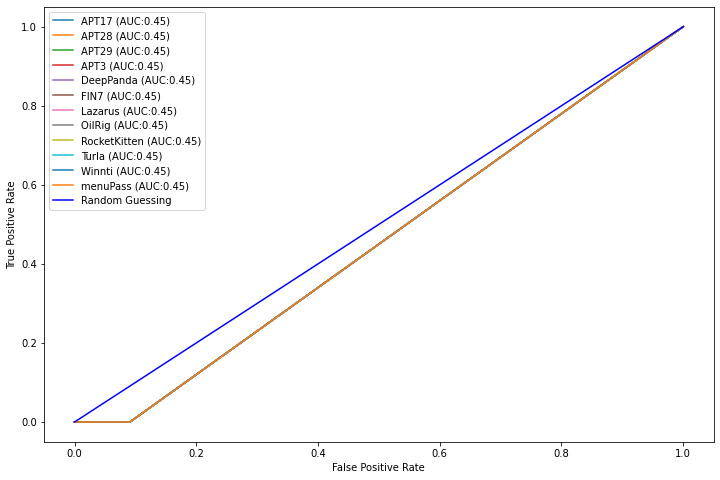

In [19]:
# Val_ds RUC_AUC Curves
ConfusionM = confusion_matrix(list(y_labels), y_hat_classes, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
class_report = classification_report(list(y_labels), y_hat_classes, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
print(f'confusion matrix: \n', ConfusionM)
print(f'classification_report: \n',class_report)

import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

target= class_names

print(class_names)
for (idx, c_label) in enumerate(target):
  print(f"idx, c_label", idx, c_label)

y_labels = np.concatenate([y for x, y in val_ds], axis=-1)

y_hat_probs = hypermodel.predict(val_ds)

y_hat_classes = y_hat_probs.argmax(axis=-1)

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[idx].astype(int), y_pred[idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score 1:', multiclass_roc_auc_score(y_labels, y_hat_classes))


c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

ROC AUC score Training data: 0.4998001621735859


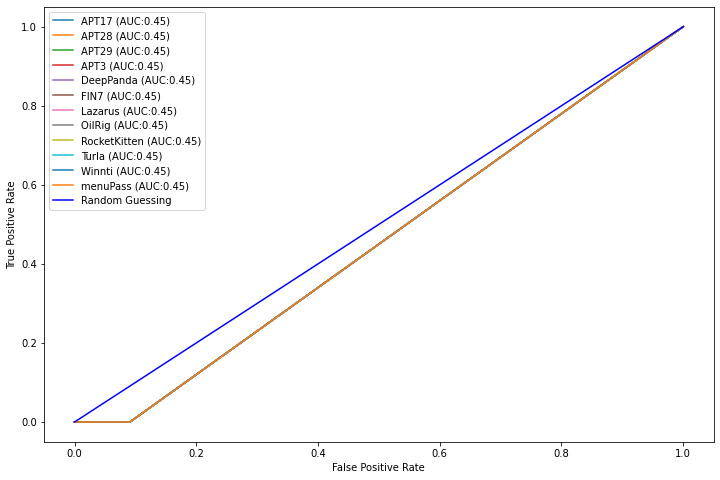

In [20]:
# Training data ruc_auc curve
y_labels = np.concatenate([y for x, y in train_ds], axis=-1)

y_hat_probs = hypermodel.predict(train_ds)

y_hat_classes = y_hat_probs.argmax(axis=-1)

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[idx].astype(int), y_pred[idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score Training data:', multiclass_roc_auc_score(y_labels, y_hat_classes))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

ROC AUC score 2: 0.5001555072786691


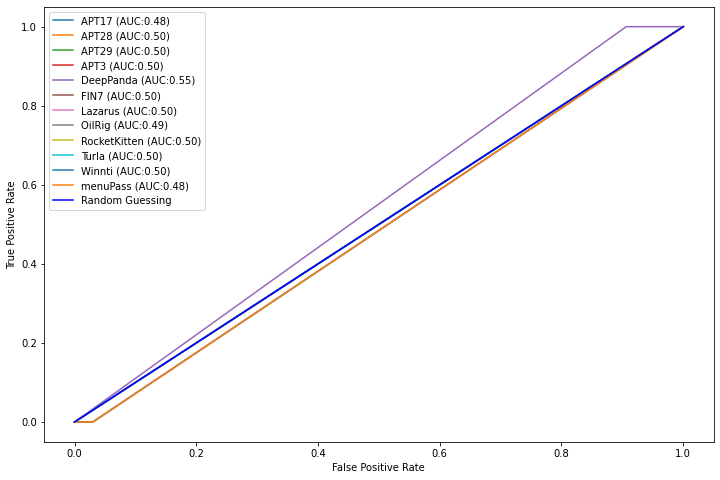

In [21]:
# Val-ds RUC AUC Curves alternate
y_labels = np.concatenate([y for x, y in val_ds], axis=-1)

y_hat_probs = hypermodel.predict(val_ds)

y_hat_classes = y_hat_probs.argmax(axis=-1)

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class2
def multiclass_roc_auc_score_2(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score 2:', multiclass_roc_auc_score_2(y_labels, y_hat_classes))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()